In [197]:
#King county

In [198]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from operator import itemgetter
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  #default='warn'


In [199]:
df = pd.read_csv('kc_house_data.csv')

In [200]:
df.isnull().values.any()

False

In [201]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [202]:
df.drop('id', axis = 1, inplace = True)
df.drop('zipcode', axis = 1, inplace = True)


df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503


In [203]:
#Feature engineering
#Converting date feature to both date and month feature.

df['date'] = pd.to_datetime(df['date'])

df['month_sold'] = df['date'].apply(lambda date:date.month)
df['year_sold'] = df['date'].apply(lambda date:date.year)

df = df.drop('date',axis=1)

print(df.columns.values)

['price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors'
 'waterfront' 'view' 'condition' 'grade' 'sqft_above' 'sqft_basement'
 'yr_built' 'yr_renovated' 'lat' 'long' 'sqft_living15' 'sqft_lot15'
 'month_sold' 'year_sold']


In [204]:
#Convert yr_renovated to is_renovated as it is a data point with higher quality for our case.
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
df['yr_renovated'].value_counts()

#Renaming the yr_renovated to is_renovated. 0 is not renovated and 1 is renovated to create a binary feature.
df.rename(columns={'yr_renovated':'is_renovated'}, inplace=True)

#Creating house age to make numbers more relevant than the year built.
df['house_age'] = (2015-df['yr_built'])

df.drop('yr_built', axis = 1, inplace = True)


In [205]:
#Shows the dataset with changed features.
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,is_renovated,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold,house_age
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0,47.5112,-122.257,1340,5650,10,2014,60
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1,47.7210,-122.319,1690,7639,12,2014,64
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0,47.7379,-122.233,2720,8062,2,2015,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,0,47.5208,-122.393,1360,5000,12,2014,50
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0,47.6168,-122.045,1800,7503,2,2015,28


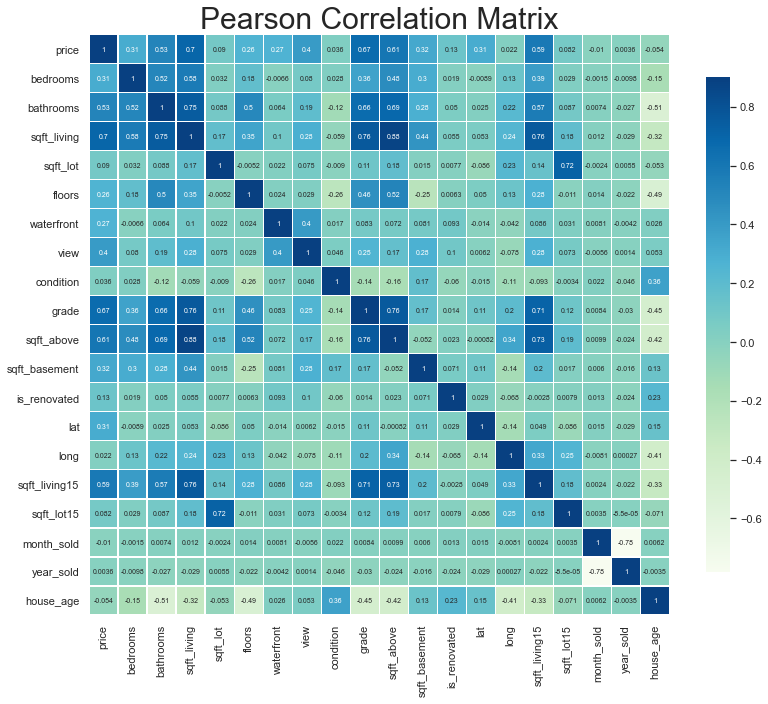

In [206]:
#We used the Seaborn library to show a Pearson Correlation Matrix. 
sns.set(style = "whitegrid", font_scale = 1)

plt.figure(figsize = (13, 13))
plt.title('Pearson Correlation Matrix',fontsize = 30)
sns.heatmap(df.corr(),linewidths = 0.3, vmax = 0.9, square = True, cmap = "GnBu", linecolor = 'w',
            annot = True, annot_kws = {"size":7}, cbar_kws = {"shrink": .7})
plt.show()

In [207]:
 #We drop the feature month_sold as it confuses the models. As it correlates weakly to price, we drop it as it does not have a big impact on the outcome of the model. 
df.drop('month_sold', axis = 1, inplace = True)

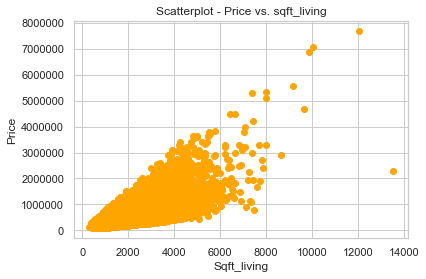

In [208]:
plt.scatter(df['sqft_living'], df['price'], c = "orange")
plt.title('Scatterplot - Price vs. sqft_living')
plt.xlabel('Sqft_living')
plt.ylabel('Price')
plt.ticklabel_format(style = 'plain')
plt.show()


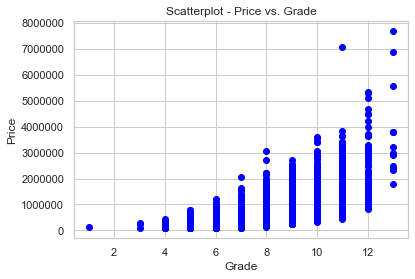

In [209]:
plt.scatter(df['grade'], df['price'], c = "blue")
plt.title('Scatterplot - Price vs. Grade')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.ticklabel_format(style = 'plain')
plt.show()

In [210]:
#We dropped the price feature to set it as the target value, to the model predicting the price depending on the other features.
X = df.drop('price', axis = 1)
y = df['price']

#We specify the test size and random state, to genereate consistent randomness.
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 99)

In [211]:
print('The shape of the training data is: ',X_train.shape)
print('The shape of the test data is: ',X_test.shape)

The shape of the training data is:  (16209, 18)
The shape of the test data is:  (5404, 18)


In [212]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,is_renovated,lat,long,sqft_living15,sqft_lot15,year_sold,house_age
137,4,2.25,2590,10002,1.0,0,0,4,8,1340,1250,0,47.7689,-122.266,1550,10436,2014,47
1641,4,2.50,2380,12573,1.0,0,0,4,9,2380,0,0,47.5984,-122.176,2900,10700,2014,52
8822,2,1.00,870,4600,1.0,0,0,4,7,870,0,0,47.5274,-122.379,930,4600,2014,73
15503,4,2.50,2250,6840,2.0,0,0,3,9,2250,0,0,47.4398,-122.151,2480,7386,2014,28
18387,3,1.50,1200,6240,1.0,0,0,3,8,1030,170,0,47.6222,-122.287,2810,6240,2014,63


In [213]:
#Two of the models we have decided to use are sensitive to underfitting/overfitting and require scaling we scale the data.

binaryFeat = ['waterfront','is_renovated']
ordFeat = ['grade','condition','view']
numFeat = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'sqft_above', 'sqft_basement', 'house_age', 'lat', 'long',
            'sqft_living15', 'sqft_lot15', 'year_sold']

OurFeaturesToScale = ordFeat + numFeat

ScalerVariable = MinMaxScaler()

X_train[OurFeaturesToScale] = ScalerVariable.fit_transform(X_train[OurFeaturesToScale])
X_test[OurFeaturesToScale] = ScalerVariable.transform(X_test[OurFeaturesToScale])

In [214]:
#Checking that it scaled the data properly. 
print('Max: ',X_train.max(), "\n")
print('Min: ', X_train.min())

Max:  bedrooms         1.0
bathrooms        1.0
sqft_living      1.0
sqft_lot         1.0
floors           1.0
waterfront       1.0
view             1.0
condition        1.0
grade            1.0
sqft_above       1.0
sqft_basement    1.0
is_renovated     1.0
lat              1.0
long             1.0
sqft_living15    1.0
sqft_lot15       1.0
year_sold        1.0
house_age        1.0
dtype: float64 

Min:  bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
is_renovated     0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
year_sold        0.0
house_age        0.0
dtype: float64


In [215]:
#Show the features with the highest correlation to price. Obviously, price will perfectly correlate with price.
price_correlation = df.corr()['price'].sort_values(ascending=False).abs()
print('Features with strongest correlation to price:\n', price_correlation[:11])

Features with strongest correlation to price:
 price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
Name: price, dtype: float64


In [216]:
#Neagtive correlation means that when house_age move in one direction, price moves in the opposite direction.
price_correlation = df.corr()['price'].sort_values(ascending = True)
print('Features with weakest correlation to price:\n',price_correlation[:11])

Features with weakest correlation to price:
 house_age      -0.054012
year_sold       0.003576
long            0.021626
condition       0.036362
sqft_lot15      0.082447
sqft_lot        0.089661
is_renovated    0.126092
floors          0.256794
waterfront      0.266369
lat             0.307003
bedrooms        0.308350
Name: price, dtype: float64


In [217]:
#Linear Regression Model
linReg = LinearRegression().fit(X_train, y_train)
print("Linear regression: Train accuracy is:  ", round(linReg.score(X_train, y_train),(4)))
print("Linear regression: Test accuracy is:        ", round(linReg.score(X_test, y_test),(4)))

cross_scores = cross_val_score(LinearRegression(), X_train, y_train, cv = 5)
print('Linear Regression: Mean cross-validation accuracy: {:.4f}'.format(np.mean(cross_scores)))

Linear regression: Train accuracy is:   0.7004
Linear regression: Test accuracy is:         0.6853
Linear Regression: Mean cross-validation accuracy: 0.6981


In [218]:
#We use SelecKBest to find the top 10 features in our dataset.
#The purpose of this is to test if the test and train accuracy will improve we use less more the most important features.
print('The shape of our dataframe, not including our target column which is price is:',X.shape)

bestK = SelectKBest(f_regression, k = 10)
bestK.fit(X_train, y_train)
X_train_bestK = bestK.transform(X_train)
X_test_bestK = bestK.transform(X_test)

print('The shape of the best features is: ',X_train_bestK.shape)
print(X.columns[bestK.get_support()])

best_features = X.columns[bestK.get_support()]

The shape of our dataframe, not including our target column which is price is: (21613, 18)
The shape of the best features is:  (16209, 10)
Index(['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'grade',
       'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'],
      dtype='object')


In [219]:
#Train, test and cross validation score decreases due to the lower amount of features.
linRegBest = LinearRegression().fit(X_train_bestK, y_train)

print('Linear Regression SelectKBest: Train score: {:.4f}'.format(linRegBest.score(X_train_bestK, y_train)))
print('Linear Regression SelectKBest: Test score: {:.4f}'.format(linRegBest.score(X_test_bestK, y_test)))

mean_best_scores = cross_val_score(LinearRegression(),X_train_bestK, y_train, cv = 5)
print('Linear Regression SelectKBest: Mean cross-validation accuracy: {:.4f}'.format(np.mean(mean_best_scores)))

Linear Regression SelectKBest: Train score: 0.6603
Linear Regression SelectKBest: Test score: 0.6455
Linear Regression SelectKBest: Mean cross-validation accuracy: 0.6582


In [220]:
#kNN Regression (without best features)
#We use GridSearchCV to find the parameter that yield highest accuracy.
paramGridKnn = {'n_neighbors': np.arange(1, 20)}
gridKnn = GridSearchCV(KNeighborsRegressor(), paramGridKnn, cv = 5)

gridKnn.fit(X_train, y_train)
print('Best cross-validation score: {}'.format(gridKnn.best_score_))
print('Best parameters:', gridKnn.best_params_)

print('Grid kNN-train score: ', gridKnn.score(X_train, y_train))
print('Grid kNN-test score: ',gridKnn.score(X_test, y_test))

Best cross-validation score: 0.761206739500632
Best parameters: {'n_neighbors': 5}
Grid Knn-train score:  0.8543886005829058
Grid Knn-test score:  0.7638879638009402


In [221]:
#kNN Regression - 10 best features
#Examining if accuracy can be improved by only using the 10 best features.
paramGridKnn1 = {'n_neighbors': np.arange(1, 20)}
gridKnn1 = GridSearchCV(KNeighborsRegressor(), paramGridKnn1, cv = 5)

gridKnn1.fit(X_train_bestK, y_train)

print('Grid Knn SelecKBest: Train score: ', gridKnn1.score(X_train_bestK, y_train))
print('Grid Knn SelecKBest: Test score: ',gridKnn1.score(X_test_bestK, y_test))

print('Best Gridd knn cross-validation score: {}'.format(gridKnn1.best_score_))
print('Best parameters:', gridKnn1.best_params_)

Grid Knn SelecKBest: Train score:  0.8190910207294124
Grid Knn SelecKBest: Test score:  0.7719107843259307
Best Gridd knn cross-validation score: 0.7677202052324514
Best parameters: {'n_neighbors': 9}


In [222]:
#Random Forest Regressor Model

numTrees = [50, 100, 150]
numMaxFeatures = [5, 10, 15]
maxLevelDepth = [2, 4, 8, 10]
maxLevelDepth.append(None)
minSamplesSplit = [2, 4]
minNumSamplesLeaf = [1, 3]

randomGrid = {'n_estimators': numTrees,
               'max_features': numMaxFeatures,
               'max_depth': maxLevelDepth,
               'min_samples_split': minSamplesSplit,
               'min_samples_leaf': minNumSamplesLeaf}

randomSearch = RandomizedSearchCV(RandomForestRegressor(), param_distributions = randomGrid, n_iter = 10, cv = 3, random_state = 99)

randomSearch.fit(X_train, y_train)

print('RandomForest search: Train score: ',randomSearch.score(X_train, y_train))
print('RandomForest search: Test score: ',randomSearch.score(X_test, y_test))
print('RandomForest search: Cross validation score is: ', randomSearch.best_score_)
print('RandomForest search: Best parameters: ',randomSearch.best_params_)

RandomForest search: Train score:  0.9264212159873023
RandomForest search: Test score:  0.8620995029330256
RandomForest search: Cross validation score is:  0.8571056847594148
RandomForest search: Best parameters:  {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 15, 'max_depth': 10}


In [223]:
#Finding the features that the Random Forest Model considers most important.
featureImportances = list(zip(randomSearch.best_estimator_.feature_importances_, X_train.columns))
sortedFeatureImportances = sorted(featureImportances, key = itemgetter(0), reverse = True)
print('The features with the highest importance: RandomForest:')
five_best_rfr = sortedFeatureImportances[0:5]

for feature in five_best_rfr:
    print(feature)

The features with the highest importance: RandomForest:
(0.33493310295217127, 'grade')
(0.28122036051700805, 'sqft_living')
(0.16299511540334272, 'lat')
(0.06582476755976387, 'long')
(0.0371338399789082, 'sqft_living15')


In [224]:
df.keys()

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'is_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'year_sold', 'house_age'],
      dtype='object')

In [225]:
#Reading prediction data. 
predictionData = pd.read_csv('Three_houses.csv')

predictionData.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,is_renovated,lat,long,sqft_living15,sqft_lot15,year_sold,house_age
0,852500,5,3.75,3830,8131,2.0,0,0,3,10,3830,0,0,47.5837,-121.971,3570,7290,2014,10
1,455000,3,1.75,890,3800,1.5,0,0,3,7,750,140,0,47.6803,-122.291,1280,3800,2015,89
2,240000,2,1.00,720,6345,1.0,0,0,3,6,720,0,0,47.5201,-122.350,720,6345,2014,72


In [226]:
predictionData.isnull().values.any()

X_to_predict = predictionData.drop('price', axis = 1)

X_to_predict[OurFeaturesToScale] = ScalerVariable.transform(X_to_predict[OurFeaturesToScale])

X_to_predict.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,is_renovated,lat,long,sqft_living15,sqft_lot15,year_sold,house_age
0,0.151515,0.46875,0.267170,0.004579,0.4,0,0.0,0.5,0.750000,0.388158,0.000000,0,0.688113,0.453333,0.588203,0.007742,0.0,0.086957
1,0.090909,0.21875,0.045283,0.001955,0.2,0,0.0,0.5,0.500000,0.050439,0.033898,0,0.843494,0.186667,0.163421,0.003672,1.0,0.773913
2,0.060606,0.12500,0.032453,0.003497,0.0,0,0.0,0.5,0.416667,0.047149,0.000000,0,0.585813,0.137500,0.059544,0.006640,0.0,0.626087


In [227]:
X_train.shape


(16209, 18)

In [228]:
X_to_predict.shape

(3, 18)

In [229]:
#Predicting prices of houses - Linear Regression
y_predict_lin_reg = linReg.predict(X_to_predict)

for prediction in y_predict_lin_reg:
    print('{:.2f}'.format(prediction))

1009282.93
427765.09
130602.43


In [230]:
#Predicting prices of houses - kNN Regression

y_predict_kNN = gridKnn.predict(X_to_predict)

for prediction in y_predict_kNN:
    print('{:.2f}'.format(prediction))

844500.00
550500.00
226700.00


In [240]:
#Predicting price of houses - RandomForestRegressor

y_predict_rfr = randomSearch.predict(X_to_predict)

for prediction in y_predict_rfr:
    print('{:.2f}'.format(prediction))

880884.99
462831.41
225985.64


In [244]:
#Reading Altered data

alteredData = pd.read_csv('AltereredTwoHouses.csv')

In [245]:
alteredData.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,is_renovated,lat,long,sqft_living15,sqft_lot15,year_sold,house_age
0,852500,5,3.75,4030,8131,2.0,0,0,4,11,4030,0,1,47.5837,-121.971,3570,7290,2014,10
1,455000,3,1.75,1090,3800,1.5,0,0,5,10,950,140,1,47.6803,-122.291,1280,3800,2015,89


In [247]:
X_altered_to_predict = alteredData.drop('price', axis = 1)

X_altered_to_predict[OurFeaturesToScale] = ScalerVariable.transform(X_altered_to_predict[OurFeaturesToScale])

X_altered_to_predict.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,is_renovated,lat,long,sqft_living15,sqft_lot15,year_sold,house_age
0,0.151515,0.46875,0.282264,0.004579,0.4,0,0.0,0.75,0.833333,0.410088,0.000000,1,0.688113,0.453333,0.588203,0.007742,0.0,0.086957
1,0.090909,0.21875,0.060377,0.001955,0.2,0,0.0,1.00,0.750000,0.072368,0.033898,1,0.843494,0.186667,0.163421,0.003672,1.0,0.773913


In [248]:
X_train.shape

(16209, 18)

In [249]:
X_altered_to_predict.shape

(2, 18)

In [250]:
#Predicting prices of houses - Linear Regression
y_altered_predict_lin_reg = linReg.predict(X_altered_to_predict)

for prediction in y_altered_predict_lin_reg:
    print('{:.2f}'.format(prediction))

1232474.95
881883.86


In [251]:
#Predicting prices of houses - kNN Regression

y_altered_predict_kNN = gridKnn.predict(X_altered_to_predict)

for prediction in y_altered_predict_kNN:
    print('{:.2f}'.format(prediction))

1929600.00
830598.00


In [252]:
#Predicting price of houses - Random Forest Regressor

y_altered_predict_rfr = randomSearch.predict(X_altered_to_predict)

for prediction in y_altered_predict_rfr:
    print('{:.2f}'.format(prediction))

1052207.18
846262.93
